The Downstream Tracking study based on sklearn framework
====================


Study of the T-Seed selection
-----------------------------
The very first baseline script describes study on **kNN classifier**.  
This is a very simple model with small number of parameters. That why is good for the baseline. 
I am pretty sure It wan't be used as a final classifier.

The study roadmap: 
1. Prepare training set. It is done by the Brunel source code. 
2. Train basic version of kNN classifier. 
3. Perform CrossValidation Grid Search to find optimal values of model parameters. 
4. Play with features. I will add some trainsformation of the initaial features.
5. Go to another model. 

In [1]:
print ("kernel is alive!")

kernel is alive!


In [2]:
import root_numpy
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import grid_search
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier


Welcome to ROOTaaS 6.06/02


As a very first step I need to grab training data form the NTpule. 
--------------------------

In [14]:
root_file = ROOT.TFile("datasets/Brunel_test_30kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)

In [15]:
data.head()

,is_true_seed,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,False,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572
1,False,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081
2,False,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975
3,False,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753
4,True,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980


Features descriptions
=================
As mentioned in the [problem description](http://localhost:7000/notebooks/SeedClasifier/Baseline.ipynb#Problem-description) paragraph the Seed classifier take into account only T-Seeds parameters. 
The input T-seeds are stored as a [Event/Track.h](https://lhcb-release-area.web.cern.ch/LHCb-release-area/DOC/rec/latest_doxygen/df/dfc/_track_8h_source.html) data structure. 

T-Seed tagging
-----------
To mark T-Seed as a good track it need to fulfil following criteria: 
1. Has associated MC (Monte Carlo) particle
2. Reconstructable as a downstream track but not as a long track 
    2.1 Has clusters only in the TT and T station
    2.2 No hits in Velo
3. The MC particle is not an electron

See [implementation](https://github.com/adendek/DownstreamTracking/blob/master/BrunelCode/Tr/PatDebugTTTruthTool.cpp#L220). 

Meaning of each T-Seed parameters
---------------

1. seed_chi2PerDof - track's chi^2 per degree of freedom of the track,  
2. seed_p, seed_pt - momentum and transverse momentum of this track,
3. seed_nLHCbIDs - number of hits associated to the T-Seed,
4. seed_niIT -  number of IT hits associated to the T-Seed,
5. seed - number of used T station layers,
6. seed_x, seed_y - x and y coordinate T-Seed projection onto first plate of T-Station
7. seed_tx, seed_ty - x and y coordinate of the T-Seed slope

See [implementation](https://github.com/adendek/DownstreamTracking/blob/master/BrunelCode/Tr/PatDebugTTTruthTool.cpp#L282) of the code responsive for creation of the training NTuple. 


In [5]:
features.describe()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
count,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,2.141347,2.225830e+04,2.127795e+03,17.798359,2.588307,11.170937,3.317441,-6.316094,0.004205,-0.000737
std,1.445885,1.704238e+06,1.898642e+05,4.677713,4.628399,1.080211,696.178473,560.443332,0.319808,0.072848
min,0.000250,1.112569e+03,1.762072e+00,8.000000,0.000000,8.000000,-2489.801279,-2277.240338,-1.284890,-0.590830
25%,1.050588,3.020143e+03,9.335554e+02,13.000000,0.000000,11.000000,-395.860601,-221.392242,-0.178821,-0.031896
50%,1.703319,5.759856e+03,1.124249e+03,19.000000,0.000000,12.000000,-3.639362,-3.872026,0.004925,-0.000357
75%,2.927111,1.318920e+04,1.370473e+03,22.000000,4.000000,12.000000,401.621860,209.766994,0.190165,0.030485
max,8.999711,1.108358e+09,1.333833e+08,32.000000,22.000000,12.000000,2505.840240,2217.239114,1.282302,0.585562


In [10]:
def print_features_histograms(features, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = numpy.percentile(features[feature], [1, 99])
        ax.hist(features.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(features.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

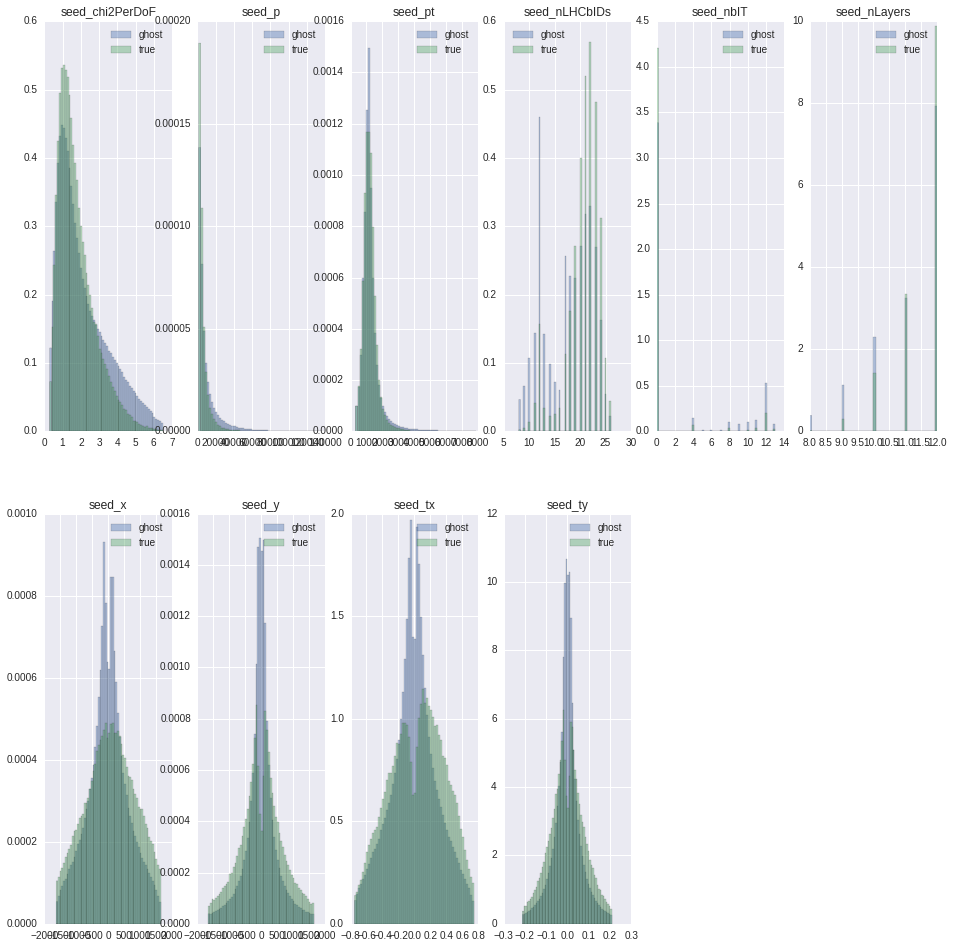

In [7]:
print_features_histograms(features, data.is_true_seed)

In [13]:
def feature_boxplot(features):
    for n, feature in enumerate(features):
    # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
        data.boxplot(feature,by='is_true_seed', ax=ax, whis='range');
        ax.legend(loc='best')      

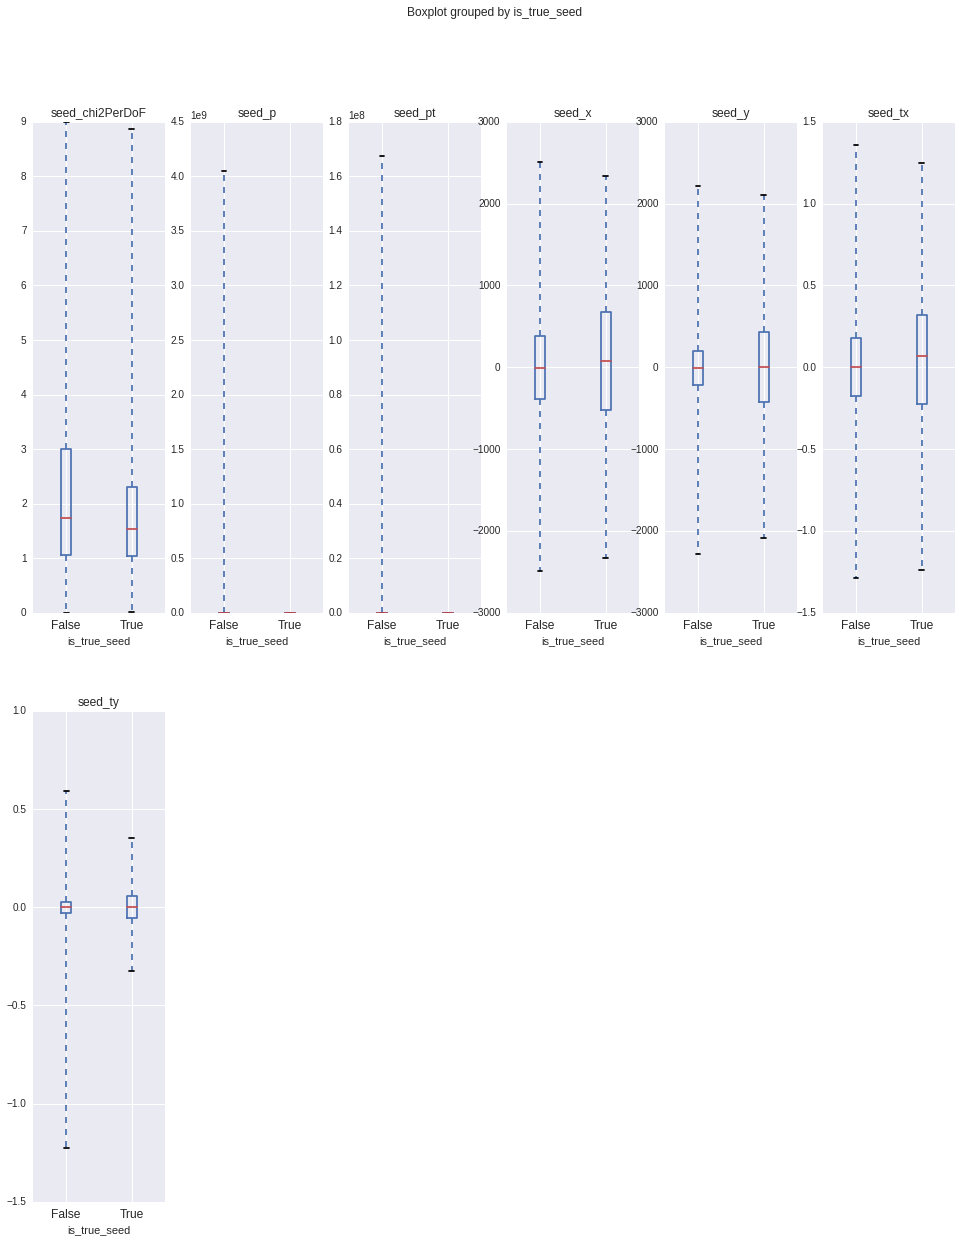

In [9]:
fig = plt.figure(figsize=(16,  20))
real_data_features = features.drop(['seed_nbIT','seed_nLHCbIDs', 'seed_nbIT','seed_nLayers' ],axis=1)
feature_boxplot(real_data_features)

Training baselines's clasifiers
=======================

Split data into train and test sets
----------------------

In [6]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.9 )

At first try kNN. 
---------------
As a k I choose arbitrary value equal to 6. This value can be tuned via grid search but it is pointless. 
I am not using any of the feature engenering. I just want to create very low level baseline.

Follow to the suggestion I normalize the features. 

In [11]:
knn = Pipeline([
  ('feature_scale', StandardScaler() ),
  ('classification', KNeighborsClassifier(n_neighbors=20))
])
knn.fit(trainX,trainY)

Pipeline(steps=[('feature_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classification', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=20, p=2, weights='uniform'))])

In [12]:
print "ROC AUC score"
roc_auc_score(testY, knn.predict_proba(testX)[:, 1])

ROC AUC score


0.75089479771986101

Cross Validation score

In [13]:
scores = cross_validation.cross_val_score(knn,
                                          features, target,
                                          scoring="roc_auc",
                                          n_jobs=6,
                                          cv=3);
"Accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())

'Accuracy: 0.75164 (+/- 0.01645)'

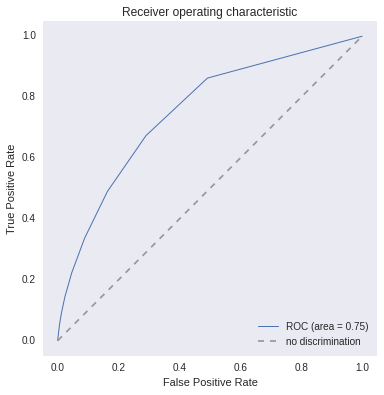

In [14]:
fpr, tpr, thresholds = roc_curve(testY, knn.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Hyperparameters optimalization
----------------
Let's improve it by serching for the best hyperparameters values. For the very basic algorithm like kNN we can only play with:
* k - number of neighbours. 
  * The cosidered range of k is between 20 and 600
* metrics. Possible choices see [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html)
* I use only 10% of data for grid search. Should be enough
* We can also look at the different optimalization algorithms such as BallTree or KDTree. But it should has no impact on classiffier performance

----------------------

In [ ]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(features, target, random_state=42,train_size=0.1 )
knn_grid_params = {"classification__n_neighbors": [x  for x in range(19,601) if x % 20 == 0],
                  "classification__metric": ['minkowski']}
print(knn_grid_params)

knn_gs = Pipeline([
  ('feature_scale', StandardScaler() ),
  ('classification', KNeighborsClassifier())
])

clf = grid_search.GridSearchCV(knn_gs,
                               knn_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=8);
clf.fit(train_gs_X, train_gs_Y);

In [7]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'classification__metric': 'minkowski', 'classification__n_neighbors': 240}
Grid scores on development set:
0.716 (+/-0.003) for {'classification__metric': 'minkowski', 'classification__n_neighbors': 20}
0.740 (+/-0.002) for {'classification__metric': 'minkowski', 'classification__n_neighbors': 40}
0.750 (+/-0.002) for {'classification__metric': 'minkowski', 'classification__n_neighbors': 60}
0.754 (+/-0.001) for {'classification__metric': 'minkowski', 'classification__n_neighbors': 80}
0.757 (+/-0.003) for {'classification__metric': 'minkowski', 'classification__n_neighbors': 100}
0.758 (+/-0.003) for {'classification__metric': 'minkowski', 'classification__n_neighbors': 120}
0.759 (+/-0.002) for {'classification__metric': 'minkowski', 'classification__n_neighbors': 140}
0.760 (+/-0.002) for {'classification__metric': 'minkowski', 'classification__n_neighbors': 160}
0.760 (+/-0.002) for {'classification__metric': 'minkowski', 'classificati

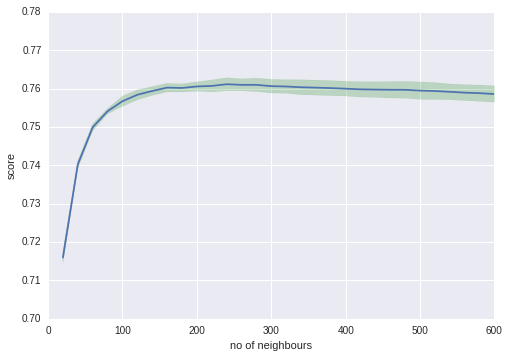

In [17]:
params = [x[0] for x in clf.grid_scores_]
scores = numpy.array([x[1] for x in clf.grid_scores_])
scores_std = numpy.array([x[2].std() for x in clf.grid_scores_])

x = numpy.array([x  for x in range(19,601) if x % 20 == 0])
plt.figure()
plt.plot(x,scores)
plt.fill_between(x, scores -  scores_std,
                 scores + scores_std, alpha=0.2, color="g")
plt.ylim(0.70, 0.78)
plt.xlabel('no of neighbours')
plt.ylabel('score')
plt.show()

Final (without FE) model score
-------

In [10]:
final_knn = Pipeline([
  ('feature_scale', StandardScaler() ),
  ('classification', KNeighborsClassifier(n_neighbors=240))
])
final_knn.fit(trainX,trainY)

Pipeline(steps=[('feature_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classification', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=240, p=2, weights='uniform'))])

In [12]:
print "ROC AUC score"
roc_auc_score(testY, final_knn.predict_proba(testX)[:, 1])

ROC AUC score


0.77671404882170592

This is very nice result!  ROC_AUC = 0.77671404882170592
------------------------

Feature Engenering
======================
Add transformated features
-------------------
At the begining let's try some very basic feature transformation. For instance log the momentums and take abs of simetrical distributed features. 

In [7]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=numpy.abs(data['seed_x'])
    out["abs_seed_y"]=numpy.abs(data['seed_y'])
    out["abs_seed_tx"]=numpy.abs(data['seed_tx'])
    out["abs_seed_ty"]=numpy.abs(data['seed_ty'])
    out['seed_r'] = numpy.sqrt(numpy.square(data.seed_x) +numpy.square(data.seed_y))    
    out['pseudo_rapidity'] = numpy.arctanh(data.seed_pt/data.seed_p)
    return out

In [16]:
new_data = basic_transforamtion(data)
new_features = new_data.drop("is_true_seed", axis=1).astype(numpy.float64)
new_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572,1263.157617,517.249191,0.524220,0.061572,1364.959300,0.505958
1,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081,1264.522435,99.363473,0.480288,0.009081,1268.420312,0.463589
2,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975,1521.093160,196.064807,0.382802,0.025975,1533.677219,0.374842
3,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753,1563.145597,483.850246,0.369674,0.058753,1636.317578,0.366082
4,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980,1641.727752,411.084316,0.646627,0.054980,1692.412576,0.610352


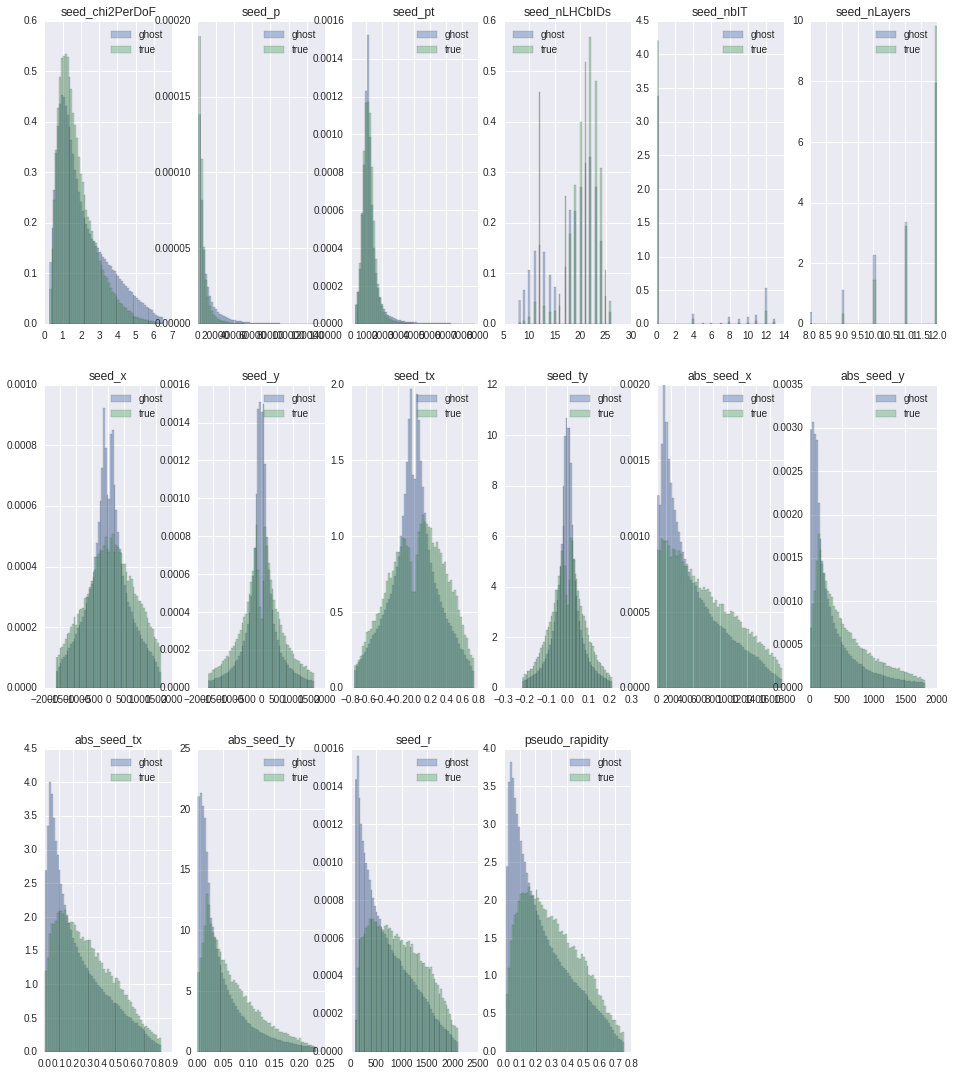

In [11]:
print_features_histograms(new_features, target)

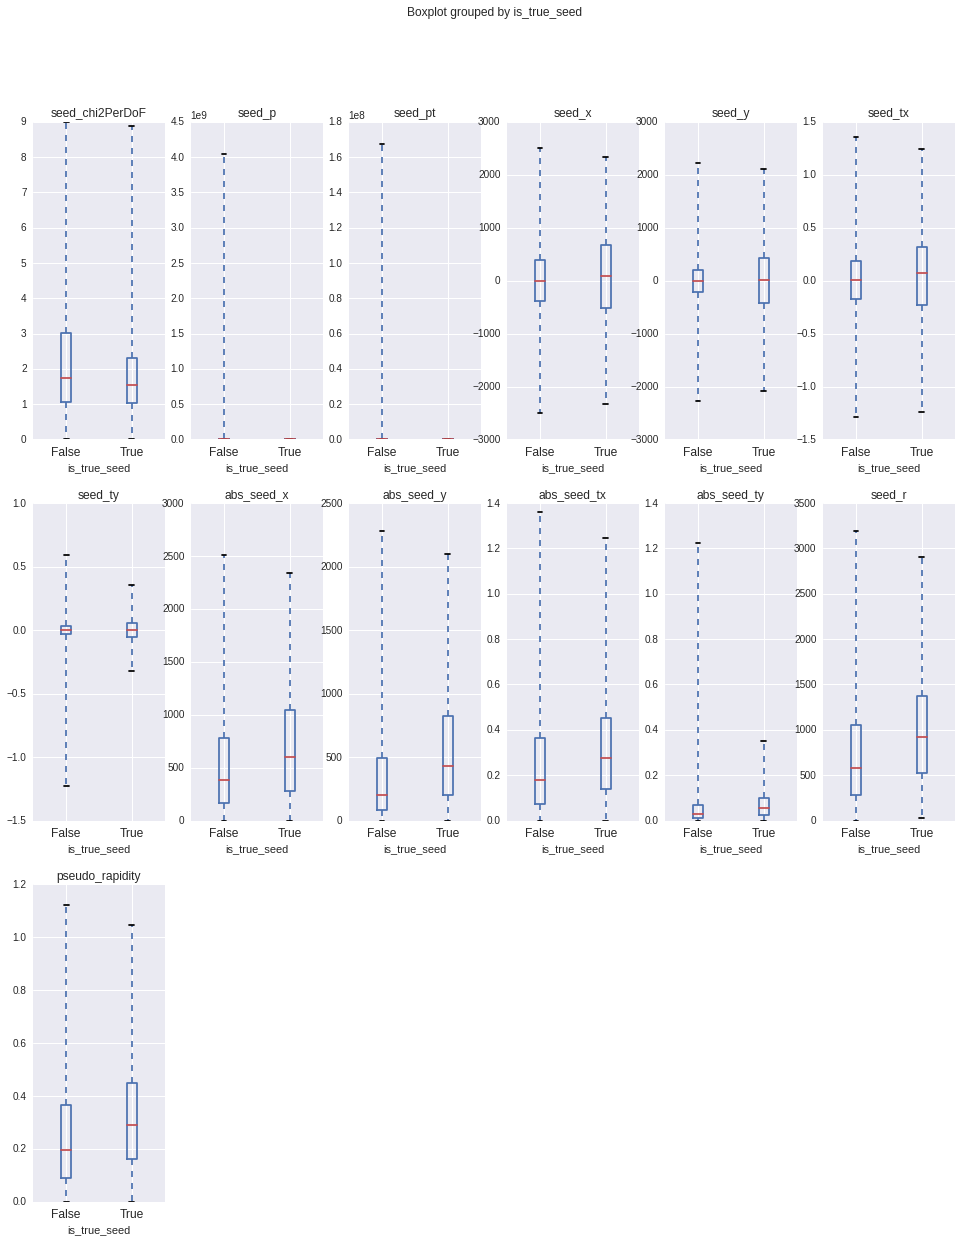

In [14]:
fig = plt.figure(figsize=(16,  20))
new_real_data_features = new_features.drop(['seed_nbIT','seed_nLHCbIDs', 'seed_nbIT','seed_nLayers' ],axis=1)
feature_boxplot(new_real_data_features)

Draw the correlation Matrix

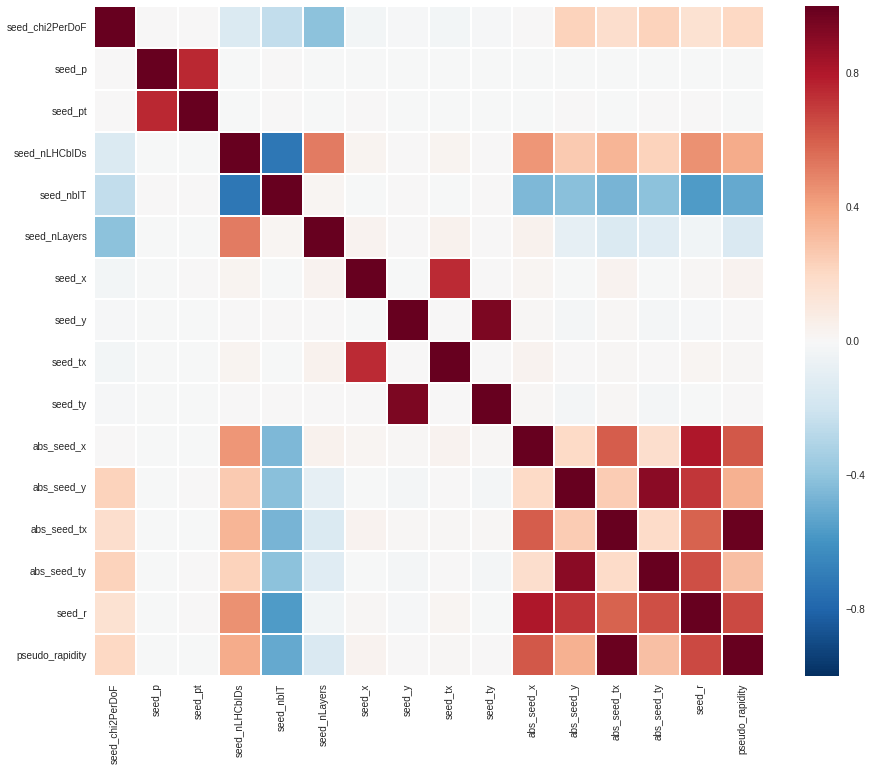

In [20]:
cor_mat = new_features.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax);

Try KNN for the new features

In [17]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.9 )

In [18]:
knn2 = Pipeline([
  ('feature_scale', StandardScaler() ),
  ('classification', KNeighborsClassifier(n_neighbors=240))
])
knn2.fit(new_trainX,new_trainY)

Pipeline(steps=[('feature_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classification', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=240, p=2, weights='uniform'))])

In [19]:
print "ROC AUC score"
roc_auc_score(new_testY, knn2.predict_proba(new_testX)[:, 1])

ROC AUC score


0.78705035119988787

Now you can go to the next model - [Baseline-BDT](https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/Baseline-BDT.ipynb) !  
--------------